### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [6]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/ehdgus575/.conda/envs/cuda_setting/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [7]:
train_images = glob.glob('/data/segmentation/ISIC-2017/trainset/images/*')
train_labels = glob.glob('/data/segmentation/ISIC-2017/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/ISIC-2017/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/ISIC-2017/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 2000 elements
My custom valing-dataset has 150 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

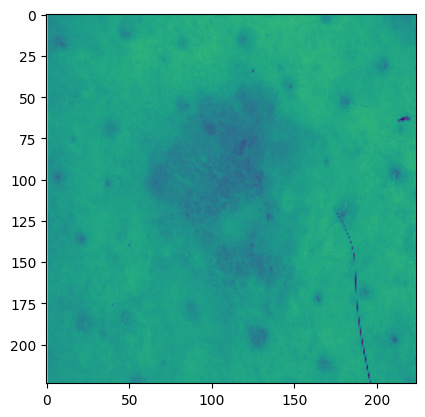

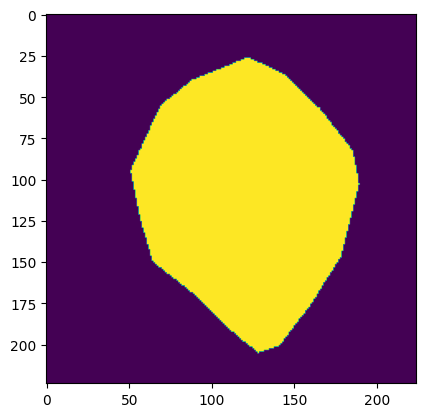

3픽셀의 평균값이라 색깔이 변경됨.


In [8]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [5]:
from models.sotor_medical_seg_models.ESFPNet.ESFPmodel import ESFPNetStructure

model = ESFPNetStructure(embedding_dim = 224)
model = model.to(DEVICE)

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [10]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [11]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'ESFPNet'
data_name = 'ISIC'

# 5. Training

/home/ehdgus575/.conda/envs/cuda_setting/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 250 of 250, Train Loss: 0.331622, IoU: 0.693637, Dice: 0.789038
 Epoch: 1 of 100, Iter.: 250 of 250, Valid Loss: 0.419804, IoU: 0.669420, Dice: 0.766374

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


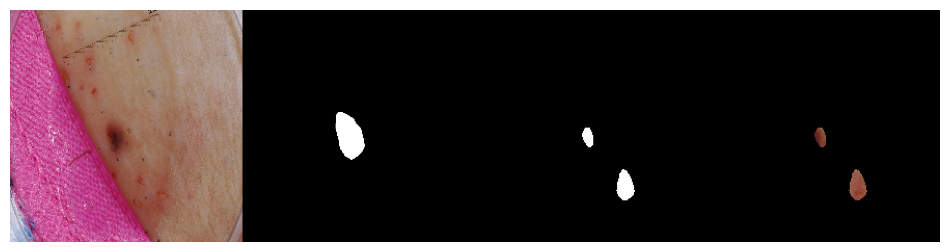

 Epoch: 2 of 100, Iter.: 250 of 250, Train Loss: 0.213832, IoU: 0.791347, Dice: 0.870501
 Epoch: 2 of 100, Iter.: 250 of 250, Valid Loss: 0.365764, IoU: 0.738024, Dice: 0.823045


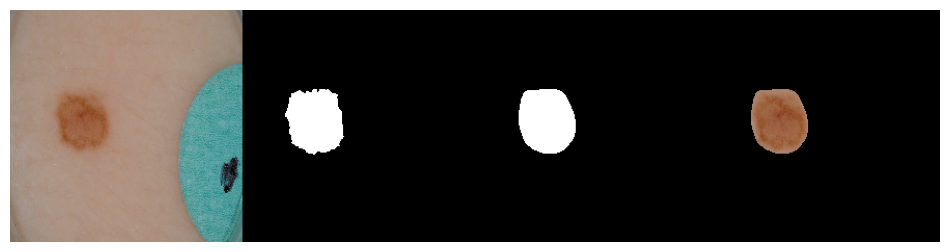

 Epoch: 3 of 100, Iter.: 250 of 250, Train Loss: 0.180957, IoU: 0.821060, Dice: 0.892877
 Epoch: 3 of 100, Iter.: 250 of 250, Valid Loss: 0.481297, IoU: 0.684554, Dice: 0.784281


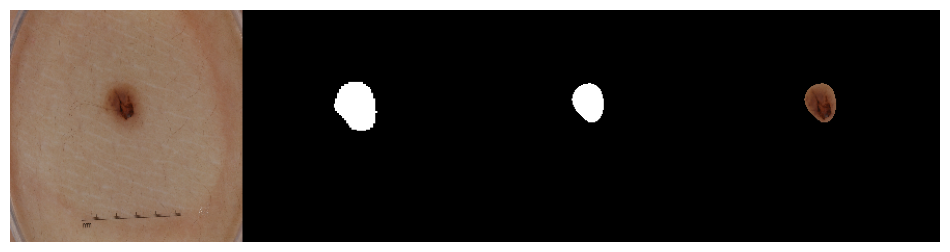

 Epoch: 4 of 100, Iter.: 250 of 250, Train Loss: 0.182334, IoU: 0.824405, Dice: 0.895291
 Epoch: 4 of 100, Iter.: 250 of 250, Valid Loss: 0.362060, IoU: 0.743094, Dice: 0.826263


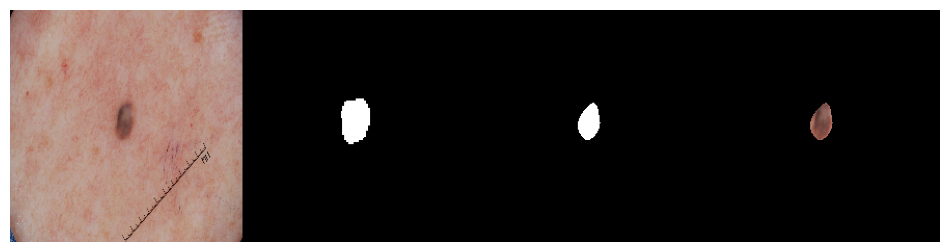

 Epoch: 5 of 100, Iter.: 250 of 250, Train Loss: 0.154433, IoU: 0.845067, Dice: 0.910071
 Epoch: 5 of 100, Iter.: 250 of 250, Valid Loss: 0.377336, IoU: 0.751105, Dice: 0.835658


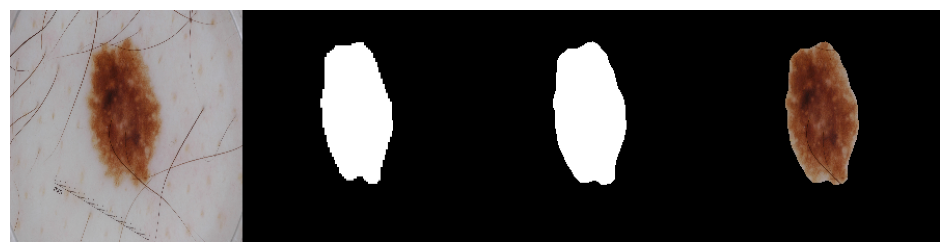

 Epoch: 6 of 100, Iter.: 250 of 250, Train Loss: 0.144678, IoU: 0.851046, Dice: 0.913987
 Epoch: 6 of 100, Iter.: 250 of 250, Valid Loss: 0.338326, IoU: 0.767395, Dice: 0.847918


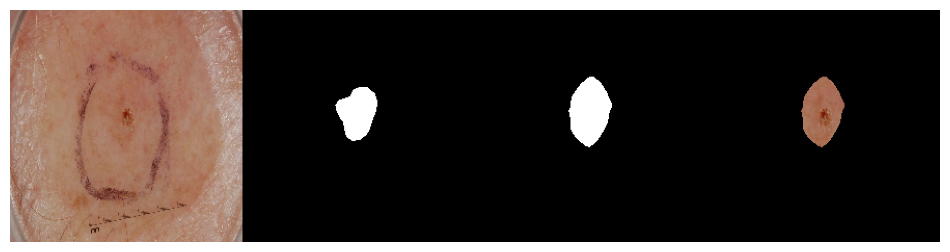

 Epoch: 7 of 100, Iter.: 250 of 250, Train Loss: 0.131467, IoU: 0.861208, Dice: 0.921237
 Epoch: 7 of 100, Iter.: 250 of 250, Valid Loss: 0.340012, IoU: 0.766003, Dice: 0.847247


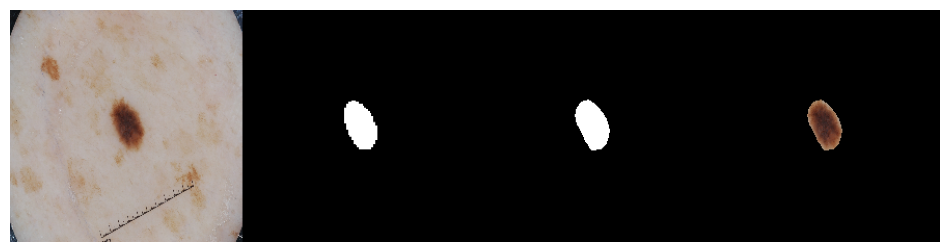

 Epoch: 8 of 100, Iter.: 250 of 250, Train Loss: 0.128774, IoU: 0.863129, Dice: 0.922016
 Epoch: 8 of 100, Iter.: 250 of 250, Valid Loss: 0.348294, IoU: 0.766325, Dice: 0.847209


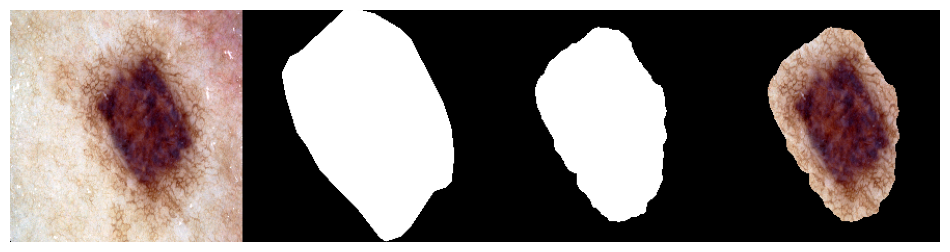

 Epoch: 9 of 100, Iter.: 250 of 250, Train Loss: 0.124609, IoU: 0.867346, Dice: 0.925534
 Epoch: 9 of 100, Iter.: 250 of 250, Valid Loss: 0.294145, IoU: 0.781954, Dice: 0.864310


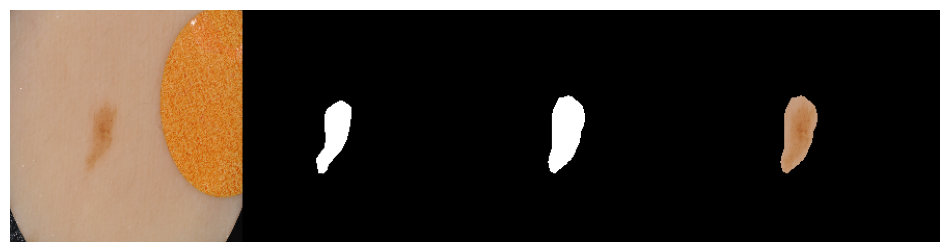

 Epoch: 10 of 100, Iter.: 250 of 250, Train Loss: 0.124189, IoU: 0.869891, Dice: 0.926571
 Epoch: 10 of 100, Iter.: 250 of 250, Valid Loss: 0.341484, IoU: 0.777367, Dice: 0.858442


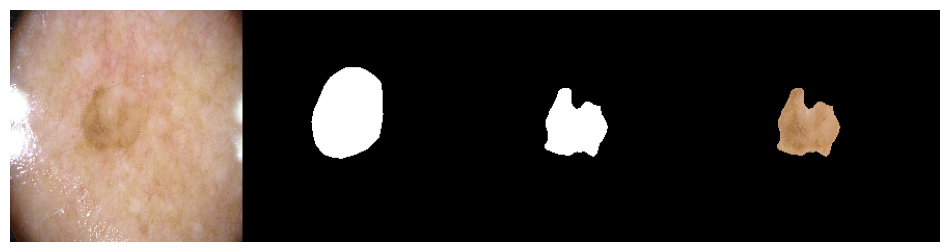

 Epoch: 11 of 100, Iter.: 250 of 250, Train Loss: 0.114053, IoU: 0.875121, Dice: 0.930007
 Epoch: 11 of 100, Iter.: 250 of 250, Valid Loss: 0.465119, IoU: 0.754573, Dice: 0.841370


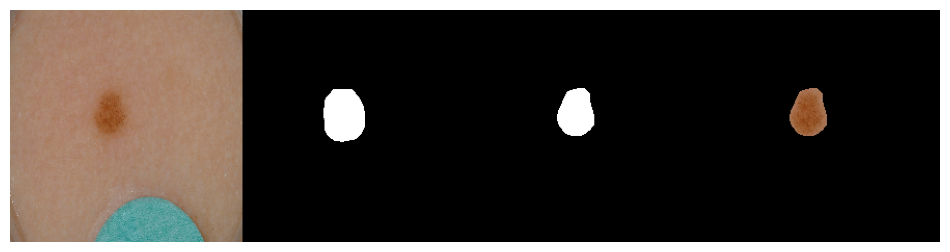

 Epoch: 12 of 100, Iter.: 250 of 250, Train Loss: 0.111882, IoU: 0.877654, Dice: 0.931540
 Epoch: 12 of 100, Iter.: 250 of 250, Valid Loss: 0.378480, IoU: 0.765634, Dice: 0.845398


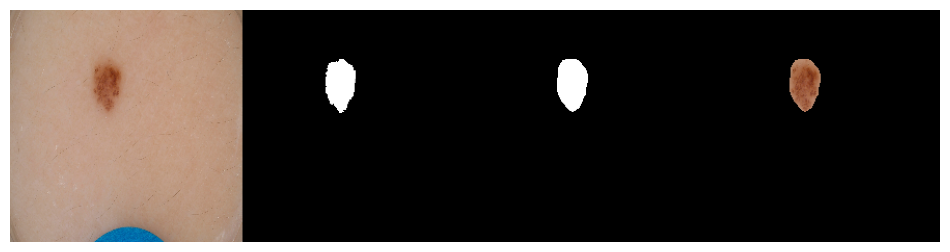

 Epoch: 13 of 100, Iter.: 250 of 250, Train Loss: 0.107207, IoU: 0.882413, Dice: 0.934625
 Epoch: 13 of 100, Iter.: 250 of 250, Valid Loss: 0.371116, IoU: 0.771127, Dice: 0.852015
 Epoch: 14 of 100, Iter.: 250 of 250, Train Loss: 0.111395, IoU: 0.879432, Dice: 0.932575
 Epoch: 14 of 100, Iter.: 250 of 250, Valid Loss: 0.350491, IoU: 0.771917, Dice: 0.854685


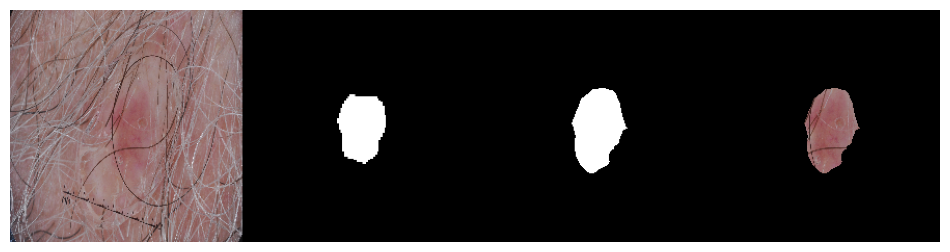

 Epoch: 15 of 100, Iter.: 250 of 250, Train Loss: 0.106292, IoU: 0.882272, Dice: 0.934118
 Epoch: 15 of 100, Iter.: 250 of 250, Valid Loss: 0.403823, IoU: 0.763468, Dice: 0.844978


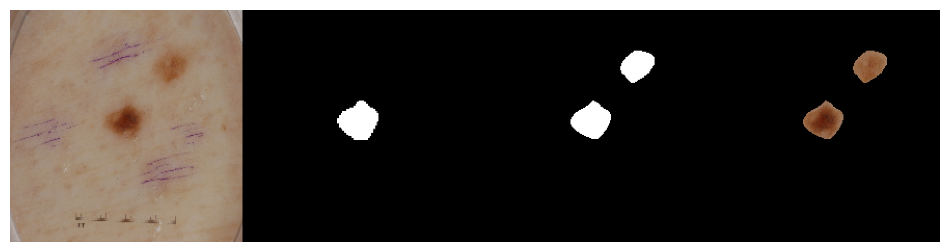

 Epoch: 16 of 100, Iter.: 250 of 250, Train Loss: 0.093818, IoU: 0.894055, Dice: 0.942371
 Epoch: 16 of 100, Iter.: 250 of 250, Valid Loss: 0.430020, IoU: 0.775321, Dice: 0.855637


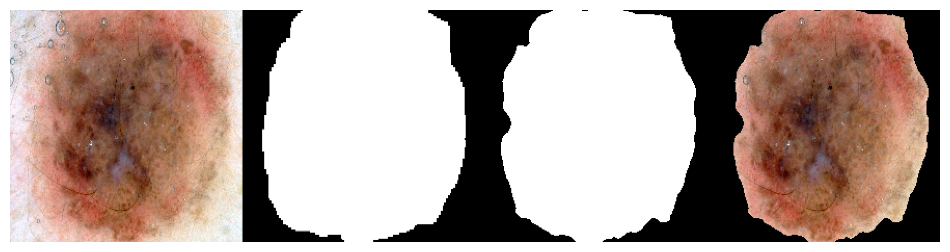

 Epoch: 17 of 100, Iter.: 250 of 250, Train Loss: 0.089524, IoU: 0.898209, Dice: 0.944146
 Epoch: 17 of 100, Iter.: 250 of 250, Valid Loss: 0.462023, IoU: 0.767359, Dice: 0.848459


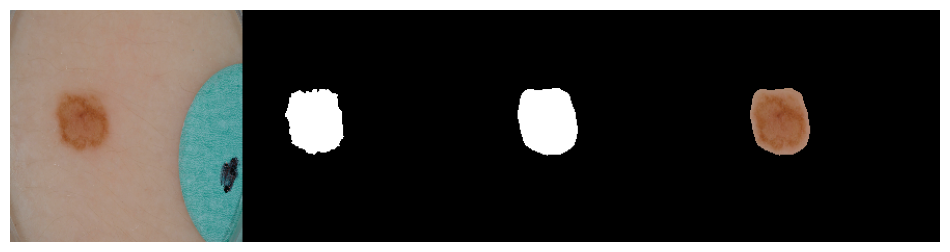

 Epoch: 18 of 100, Iter.: 250 of 250, Train Loss: 0.097496, IoU: 0.892089, Dice: 0.940623
 Epoch: 18 of 100, Iter.: 250 of 250, Valid Loss: 0.463718, IoU: 0.762208, Dice: 0.843529


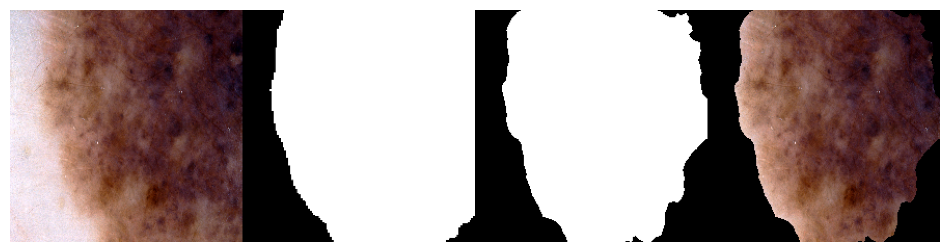

 Epoch: 19 of 100, Iter.: 250 of 250, Train Loss: 0.087020, IoU: 0.901281, Dice: 0.946424
 Epoch: 19 of 100, Iter.: 250 of 250, Valid Loss: 0.360287, IoU: 0.775772, Dice: 0.857360


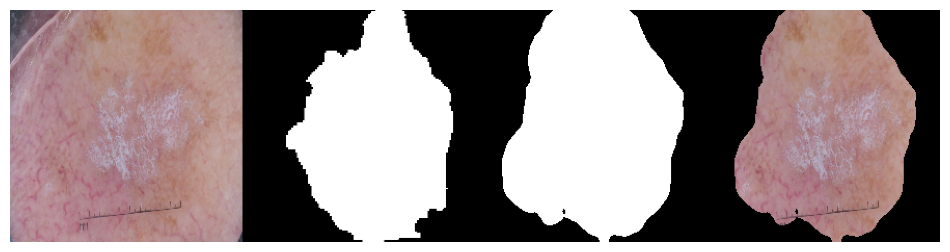

 Epoch: 20 of 100, Iter.: 250 of 250, Train Loss: 0.086705, IoU: 0.899445, Dice: 0.945038
 Epoch: 20 of 100, Iter.: 250 of 250, Valid Loss: 0.427974, IoU: 0.769916, Dice: 0.852856


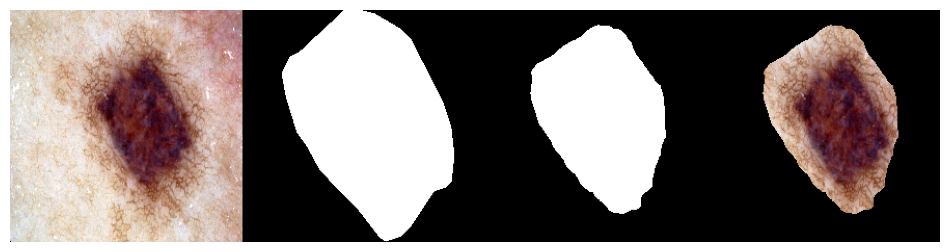

 Epoch: 21 of 100, Iter.: 250 of 250, Train Loss: 0.079513, IoU: 0.905704, Dice: 0.948975
 Epoch: 21 of 100, Iter.: 250 of 250, Valid Loss: 0.461476, IoU: 0.769621, Dice: 0.852803


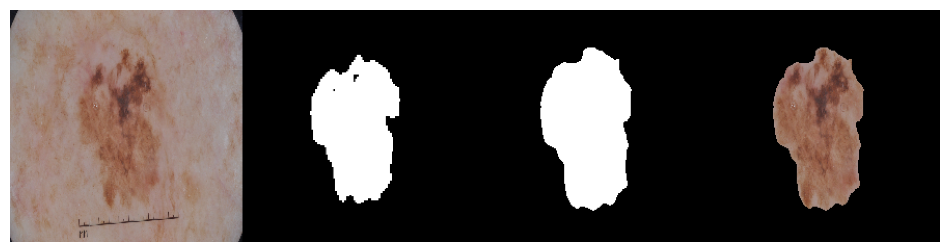

 Epoch: 22 of 100, Iter.: 250 of 250, Train Loss: 0.079379, IoU: 0.906993, Dice: 0.949655
 Epoch: 22 of 100, Iter.: 250 of 250, Valid Loss: 0.436536, IoU: 0.776901, Dice: 0.856552


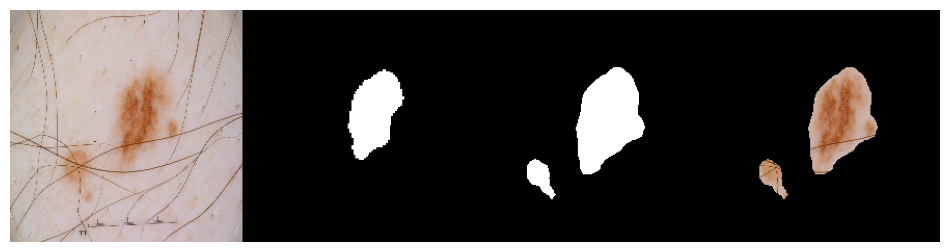

 Epoch: 23 of 100, Iter.: 250 of 250, Train Loss: 0.078941, IoU: 0.907438, Dice: 0.949992
 Epoch: 23 of 100, Iter.: 250 of 250, Valid Loss: 0.410306, IoU: 0.785089, Dice: 0.865909


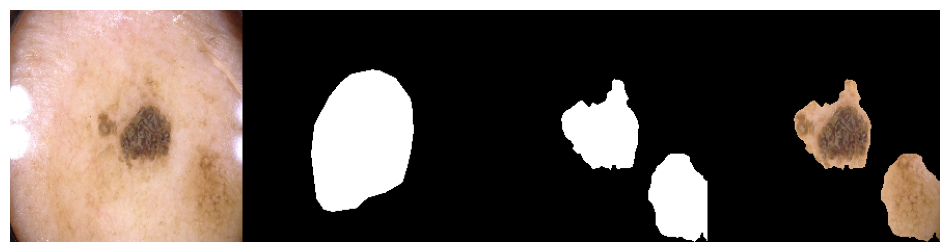

 Epoch: 24 of 100, Iter.: 250 of 250, Train Loss: 0.078496, IoU: 0.908831, Dice: 0.950514
 Epoch: 24 of 100, Iter.: 250 of 250, Valid Loss: 0.521881, IoU: 0.760275, Dice: 0.840483


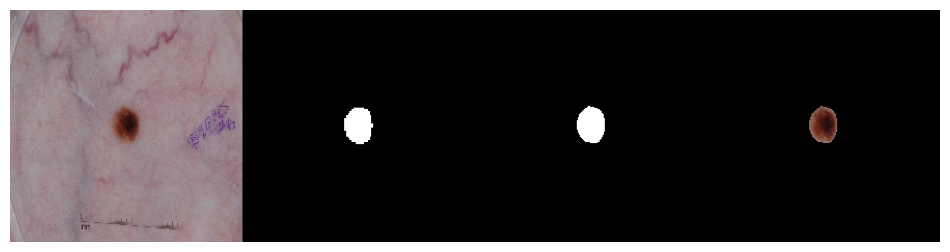

 Epoch: 25 of 100, Iter.: 250 of 250, Train Loss: 0.081920, IoU: 0.906176, Dice: 0.948875
 Epoch: 25 of 100, Iter.: 250 of 250, Valid Loss: 0.395868, IoU: 0.776440, Dice: 0.854054


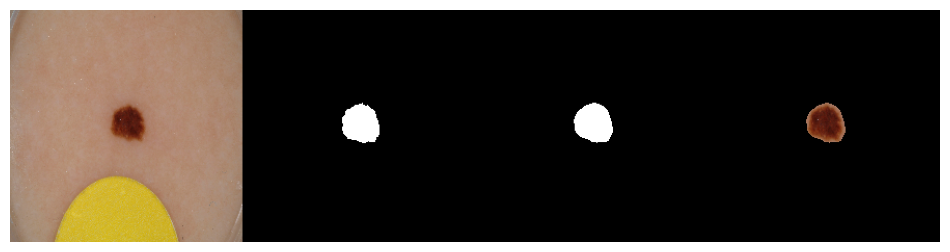

 Epoch: 26 of 100, Iter.: 250 of 250, Train Loss: 0.082970, IoU: 0.902713, Dice: 0.946891
 Epoch: 26 of 100, Iter.: 250 of 250, Valid Loss: 0.403828, IoU: 0.783928, Dice: 0.862694


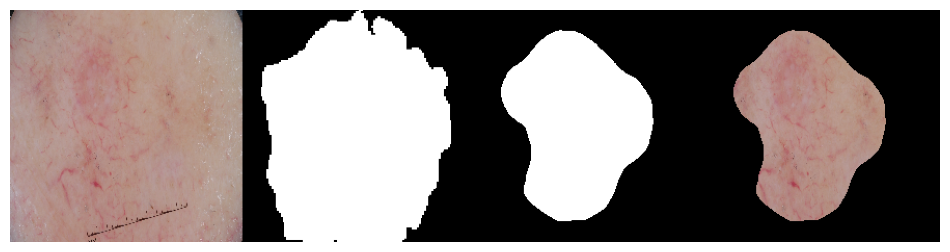

 Epoch: 27 of 100, Iter.: 250 of 250, Train Loss: 0.084952, IoU: 0.904727, Dice: 0.948298
 Epoch: 27 of 100, Iter.: 250 of 250, Valid Loss: 0.451411, IoU: 0.776671, Dice: 0.855884


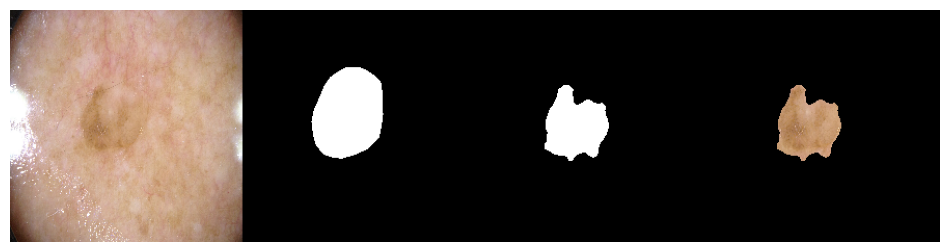

 Epoch: 28 of 100, Iter.: 250 of 250, Train Loss: 0.072943, IoU: 0.913622, Dice: 0.953425
 Epoch: 28 of 100, Iter.: 250 of 250, Valid Loss: 0.419735, IoU: 0.782668, Dice: 0.861958


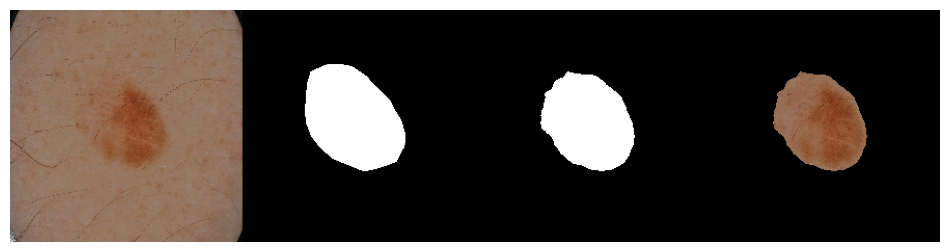

 Epoch: 29 of 100, Iter.: 250 of 250, Train Loss: 0.068990, IoU: 0.916733, Dice: 0.955365
 Epoch: 29 of 100, Iter.: 250 of 250, Valid Loss: 0.463895, IoU: 0.776653, Dice: 0.855532


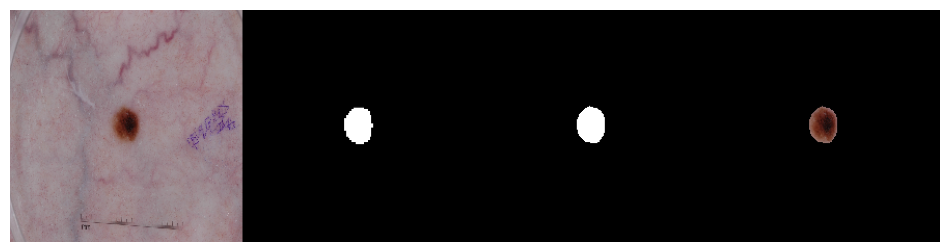

 Epoch: 30 of 100, Iter.: 250 of 250, Train Loss: 0.067649, IoU: 0.917661, Dice: 0.955684
 Epoch: 30 of 100, Iter.: 250 of 250, Valid Loss: 0.456849, IoU: 0.770806, Dice: 0.853568


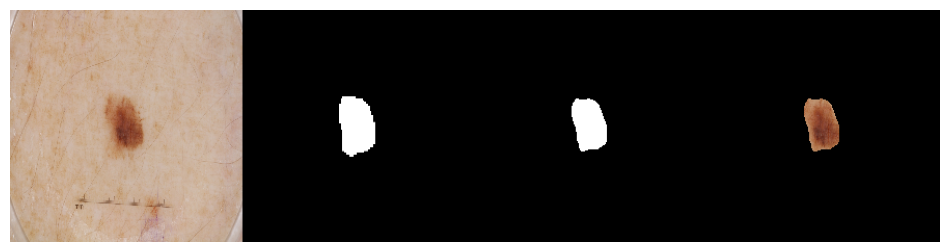

 Epoch: 31 of 100, Iter.: 250 of 250, Train Loss: 0.065755, IoU: 0.919987, Dice: 0.957367
 Epoch: 31 of 100, Iter.: 250 of 250, Valid Loss: 0.491189, IoU: 0.781958, Dice: 0.864047


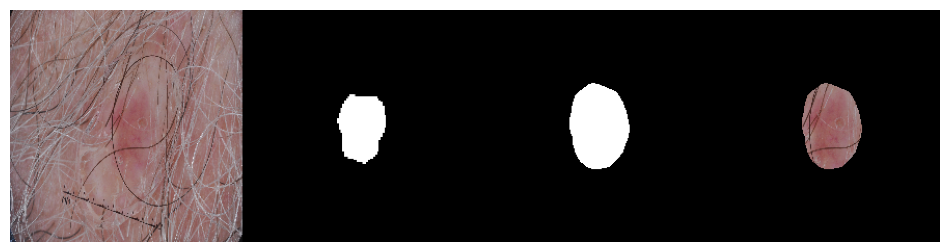

 Epoch: 32 of 100, Iter.: 250 of 250, Train Loss: 0.065986, IoU: 0.919839, Dice: 0.957195
 Epoch: 32 of 100, Iter.: 250 of 250, Valid Loss: 0.430434, IoU: 0.778225, Dice: 0.858508


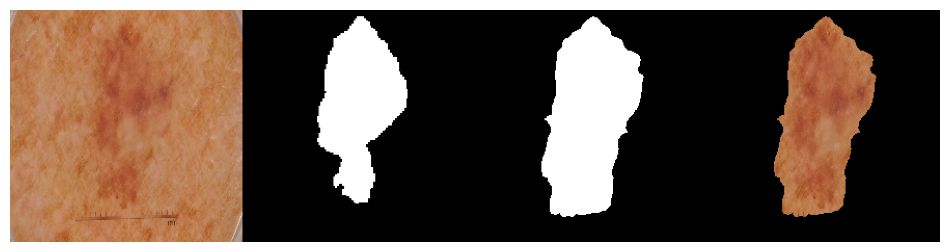

 Epoch: 33 of 100, Iter.: 250 of 250, Train Loss: 0.066235, IoU: 0.920763, Dice: 0.957655
 Epoch: 33 of 100, Iter.: 250 of 250, Valid Loss: 0.464149, IoU: 0.773742, Dice: 0.853468


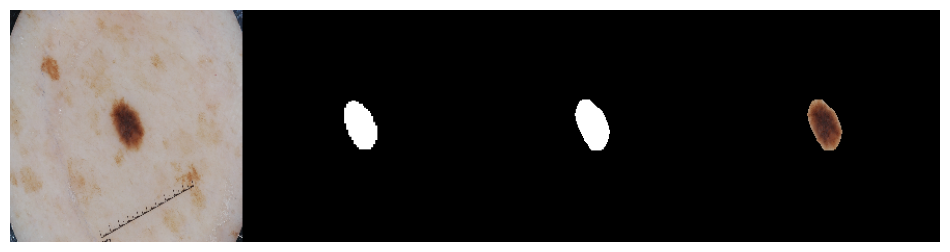

 Epoch: 34 of 100, Iter.: 250 of 250, Train Loss: 0.063557, IoU: 0.923482, Dice: 0.959414
 Epoch: 34 of 100, Iter.: 250 of 250, Valid Loss: 0.498317, IoU: 0.769326, Dice: 0.849931


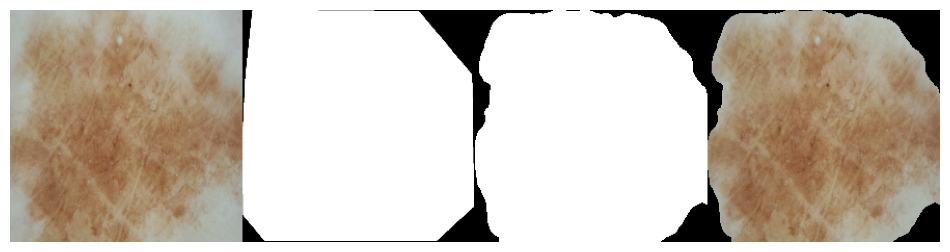

 Epoch: 35 of 100, Iter.: 250 of 250, Train Loss: 0.063663, IoU: 0.923512, Dice: 0.959334
 Epoch: 35 of 100, Iter.: 250 of 250, Valid Loss: 0.444780, IoU: 0.774316, Dice: 0.854888


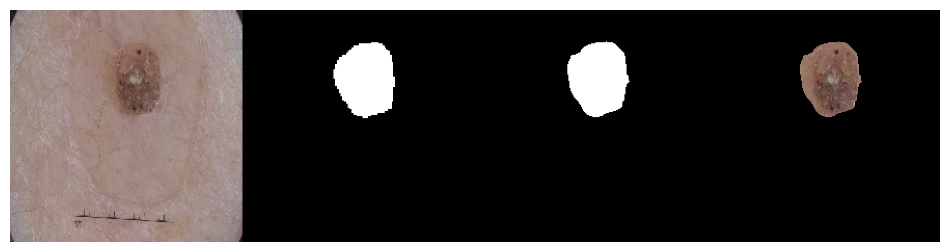

 Epoch: 36 of 100, Iter.: 250 of 250, Train Loss: 0.065269, IoU: 0.922191, Dice: 0.958507
 Epoch: 36 of 100, Iter.: 250 of 250, Valid Loss: 0.514999, IoU: 0.758722, Dice: 0.838007


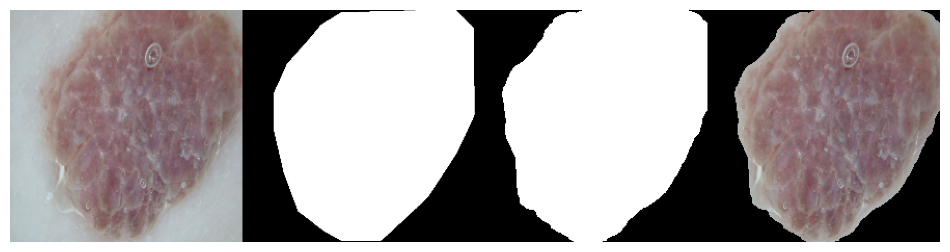

 Epoch: 37 of 100, Iter.: 250 of 250, Train Loss: 0.074537, IoU: 0.913772, Dice: 0.953128
 Epoch: 37 of 100, Iter.: 250 of 250, Valid Loss: 0.444976, IoU: 0.773535, Dice: 0.852670


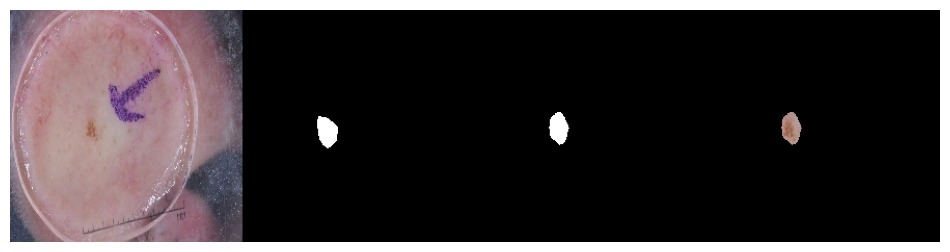

 Epoch: 38 of 100, Iter.: 250 of 250, Train Loss: 0.067418, IoU: 0.920825, Dice: 0.957779
 Epoch: 38 of 100, Iter.: 250 of 250, Valid Loss: 0.465086, IoU: 0.775703, Dice: 0.855430


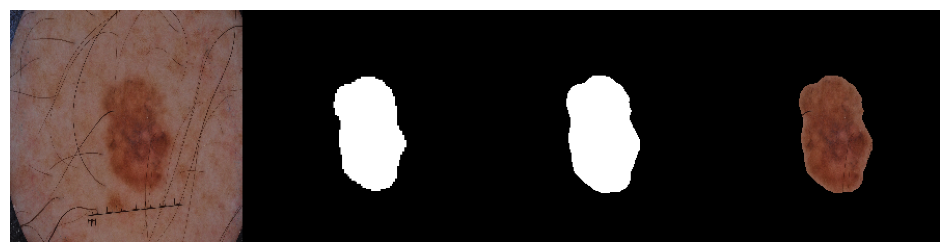

 Epoch: 39 of 100, Iter.: 250 of 250, Train Loss: 0.061340, IoU: 0.925514, Dice: 0.960473
 Epoch: 39 of 100, Iter.: 250 of 250, Valid Loss: 0.474776, IoU: 0.779656, Dice: 0.860394


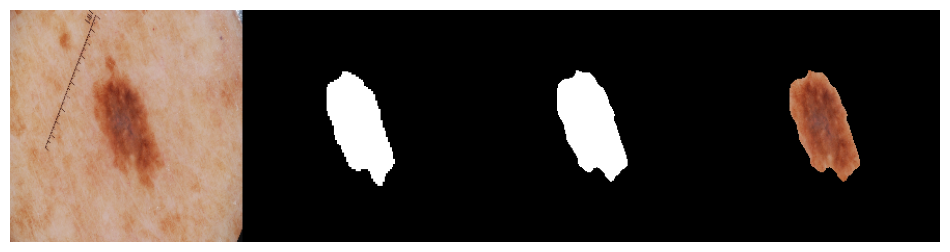

 Epoch: 40 of 100, Iter.: 250 of 250, Train Loss: 0.057512, IoU: 0.928816, Dice: 0.962322
 Epoch: 40 of 100, Iter.: 250 of 250, Valid Loss: 0.461568, IoU: 0.780580, Dice: 0.861567


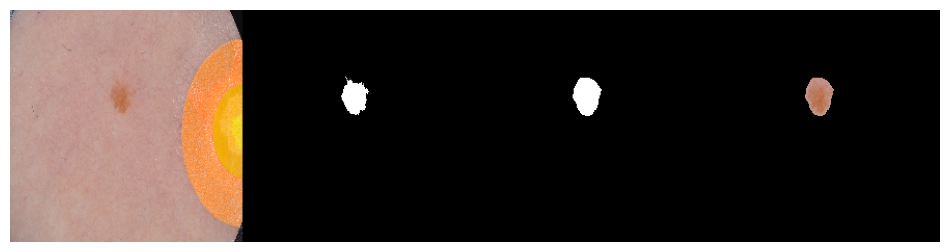

 Epoch: 41 of 100, Iter.: 250 of 250, Train Loss: 0.056613, IoU: 0.930230, Dice: 0.963131
 Epoch: 41 of 100, Iter.: 250 of 250, Valid Loss: 0.467565, IoU: 0.780205, Dice: 0.860512


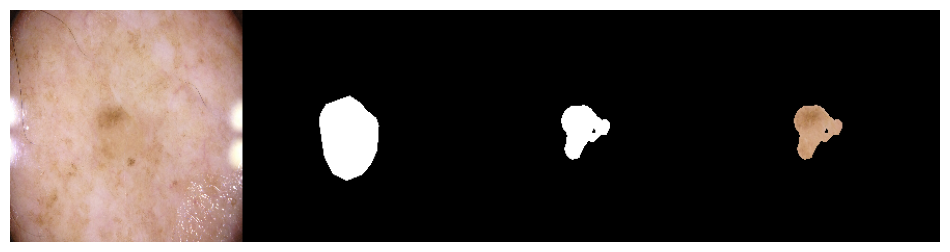

 Epoch: 42 of 100, Iter.: 250 of 250, Train Loss: 0.057257, IoU: 0.931040, Dice: 0.963616
 Epoch: 42 of 100, Iter.: 250 of 250, Valid Loss: 0.510562, IoU: 0.772245, Dice: 0.854644


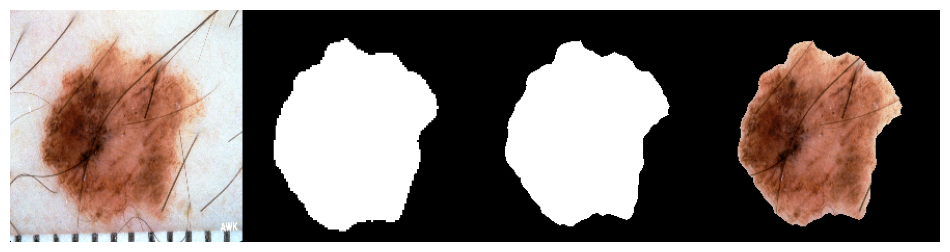

 Epoch: 43 of 100, Iter.: 250 of 250, Train Loss: 0.057918, IoU: 0.928489, Dice: 0.961972
 Epoch: 43 of 100, Iter.: 250 of 250, Valid Loss: 0.441956, IoU: 0.778858, Dice: 0.859048


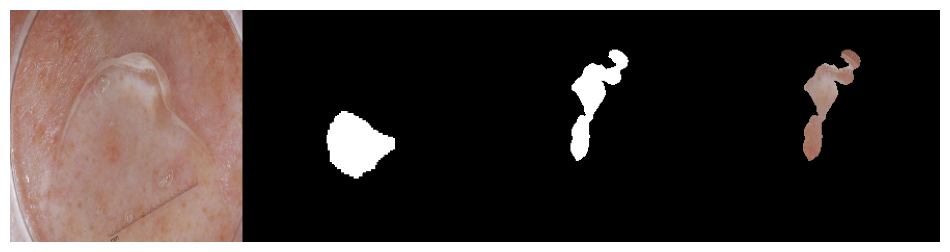

 Epoch: 44 of 100, Iter.: 250 of 250, Train Loss: 0.058901, IoU: 0.927917, Dice: 0.961716
 Epoch: 44 of 100, Iter.: 250 of 250, Valid Loss: 0.456033, IoU: 0.784578, Dice: 0.865459


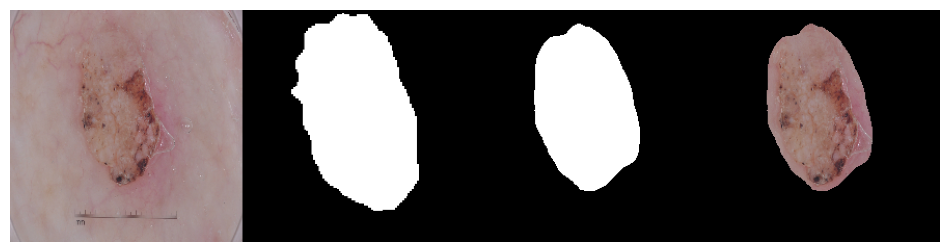


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 35min 25s, sys: 14min 55s, total: 50min 20s
Wall time: 3h 29min 49s


In [12]:
%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/ehdgus575/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:23, Best_IOU:0.7851, Best_DiceScore:0.8659


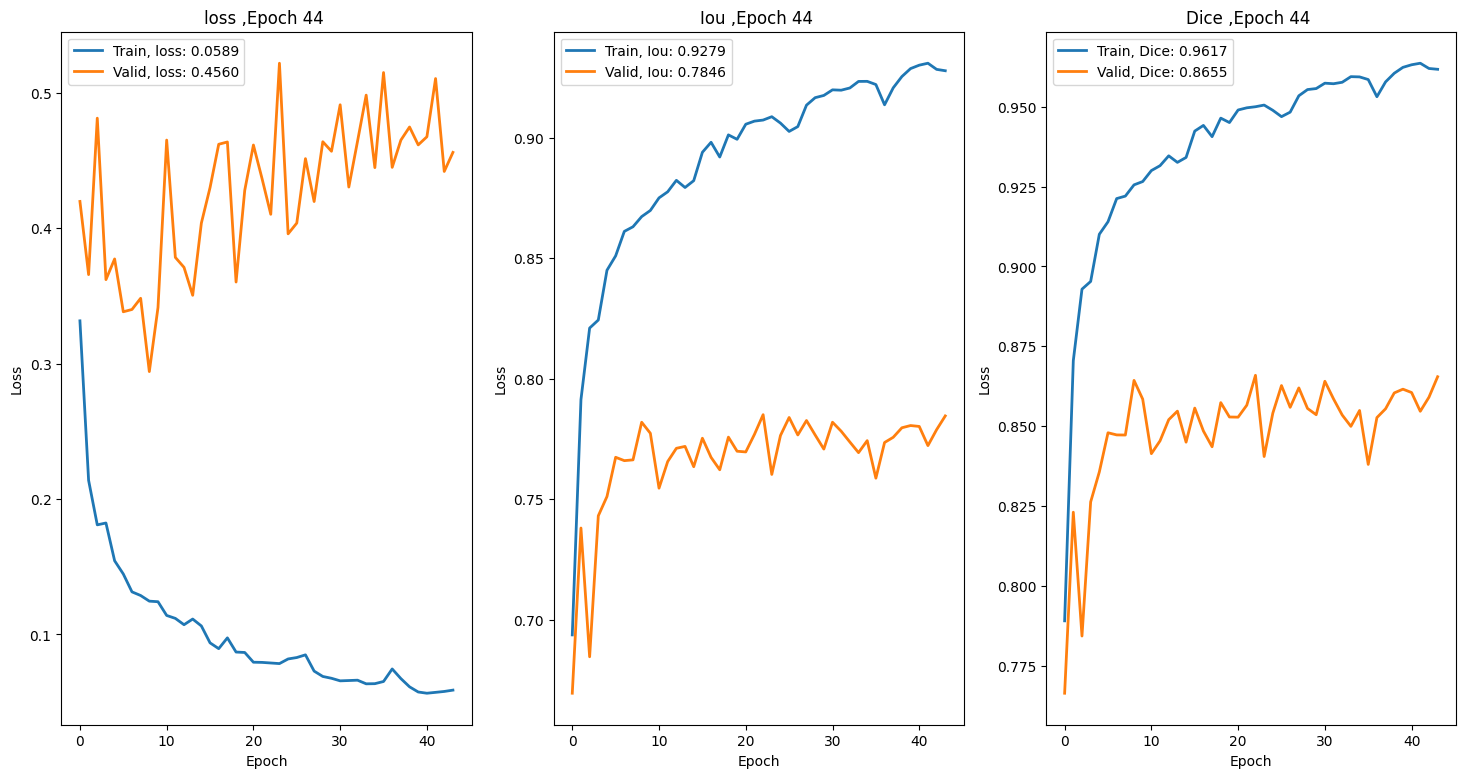

In [13]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')
#print(f'End_time: {end_time}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()